# Imports

In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import scipy
from scipy import optimize, interpolate, integrate
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

import scipy.stats as stats


# Meta-correlation
## Plotting

In [3]:
def instantiate_fig(x=7, y=6):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y, forward=True)
    font = {'weight' : 'normal', 'size'   : 20}
    plt.rc('font', **font)
    return fig, ax

def set_layout(fig, ax, legend=False):
    if legend:
        ax.legend(loc='best', handlelength=1, frameon=False)
    fig.patch.set_alpha(1)
    plt.tight_layout()
    return

## Previous
May not be needed

In [4]:
def my_fit_function_ln_keq_2(tis, a, b):
    return np.log(a*tis**b)

def meta_correlation(a, c, d):
    return c*np.log(a) + d

def get_meta_residuals(x, a_vals, b_vals):
    c = x[0]
    d = x[1]
    return b_vals - (c*np.log(a_vals) + d)

# Illustration of noise problem

In [5]:
def get_reg_intervals(x, y, alpha=0.05, line_extension=0.0):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # mean squared error
    MSE = 1/n * np.sum( residual**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x)-line_extension, np.max(x)+line_extension, 1000)
    y_line = np.polyval([slope, intercept], x_line)

    # intervals
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))
    
    return x_line, y_line, ci, pi, pred_err_var

def get_pred_err_var(x, y, x_star):
    slope, intercept = np.polyfit(x, y, 1)  
    y_model = np.polyval([slope, intercept], x)  
    residual = y - y_model

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                       
    m = 2                            
    dof = n - m   
    
    pred_err_var = (np.sum(residual**2) / dof) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    return pred_err_var
    
def plot_intervals(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_xscale('log')
    
    color = 'blue'
    ax.plot(np.exp(x), y, 'o', color = 'royalblue')
    ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
#     ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$a$')
    ax.set_yscale('log')
    
    color = 'blue'
    ax.plot(x, np.exp(y), 'o', color = 'royalblue')
    ax.plot(x_line, np.exp(y_line), color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, np.exp(y_line + pi), np.exp(y_line - pi), color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, np.exp(y_line + ci), np.exp(y_line - ci), color = 'skyblue', label = '95% CI')
    ax.legend(loc='upper right', fontsize=20)

    return fig, ax

def plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi):
    fig, ax = instantiate_fig()
    ax.set_xlabel('$b$')
    ax.set_ylabel('$ln(a)$')
    
    color = 'blue'
    ax.plot(x, y, 'o', color = 'royalblue')
    ax.plot(x_line, y_line, color = 'royalblue', linestyle='--')
    ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% PI')
    ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% CI')
    ax.legend(loc='lower left', fontsize=16)

    return fig, ax

In [6]:
# Load data
df_all_k = pd.read_csv('./lit_data/all_kprime.csv')
df_all_k.fillna(0.0, inplace=True)

df_2_fit_parms = pd.read_csv('./lit_data/two_params_all_data.csv')
resins = list(set(df_2_fit_parms.resin))
resins.sort()

df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)
data = np.zeros((len(df_2_fit_parms), 2))
data[:,0] = df_2_fit_parms.ln_a
data[:,1] = df_2_fit_parms.b

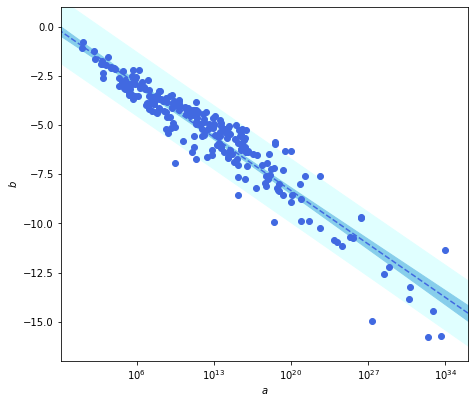

In [7]:
x = data[:,0]
y = data[:,1]

x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=5.0)
fig, ax = plot_intervals(x, y, x_line, y_line, ci, pi)
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(-17, 1)

set_layout(fig, ax)
# fig.savefig(f'./images/noise_problem/b_a_all_CI_PI_no_legend.png', dpi=300)

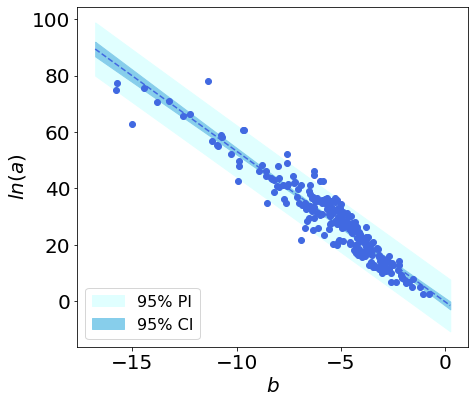

In [8]:
x = data[:,1]
y = data[:,0]

x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=1.0)
fig, ax = plot_intervals_reverse_ln(x, y, x_line, y_line, ci, pi)

set_layout(fig, ax)
# fig.savefig(f'./images/noise_problem/a_b_all_CI_PI.png', dpi=300)

In [9]:
def get_stats_from_reg(x, y, x_star, alpha=0.05):
    slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment
    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(1.0-alpha/2.0, dof) # Students statistic of interval confidence

    residual = y - y_model
    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # intervals
    pi = t * std_error * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))**.5  
    pred_err_var = (std_error**2.0) * (1 + 1/n + (x_star - x_mean)**2 / np.sum((x - x_mean)**2))
    
    y_val = np.polyval([slope, intercept], [x_star])
    low   = y_val - pi
    high  = y_val + pi
    
    return y_val, pred_err_var, low, high

# def g_a(a, mu, var):
#     g = 1.0/(np.sqrt(2.0 * np.pi * var)) * np.exp((-1.0*(np.log(a) - mu)**2)/(2 * var))
#     return g

# def get_a_integral_diff(bound, alpha, mu, var):
#     res = integrate.quad(g_a, 0.0, bound, args=(mu, var))
#     return res.y - alpha

# def get_a_bound(alpha, mu, var):
#     res = optimize.least_squares(get_a_integral_diff, 0.0, args=(alpha, mu, var))
#     return res

In [10]:
x = data[:,1]
y = data[:,0]

b_val = -5.0
mu, pre_err_var, low, high = get_stats_from_reg(x, y, b_val)
a_mean, a_low, a_high = np.exp(mu[0]), np.exp(low[0]), np.exp(high[0])

print(f'{a_mean:.3e}, {a_low:.3e}, {a_high:.3e}')

3.176e+11, 3.590e+07, 2.810e+15


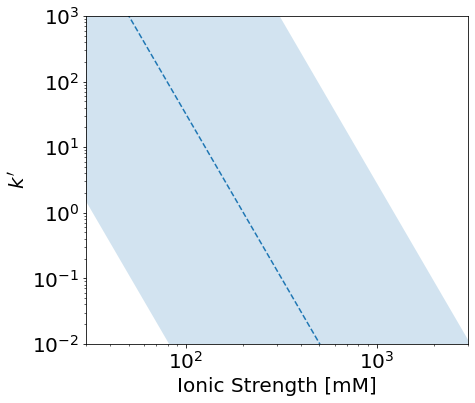

In [11]:
fig, ax = plt.subplots()
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig.set_size_inches(7, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_ylabel("$k'$")
ax.set_xlabel('Ionic Strength [mM]')

a_vals = np.logspace(0, 100, 101)
tis_new = np.linspace(10, 3e3, 1000)
for a in a_vals:
    k_mean = [a_mean*tis**b_val for tis in tis_new]
    k_low  = [a_low*tis**b_val for tis in tis_new]
    k_high = [a_high*tis**b_val for tis in tis_new]
    
ax.loglog(tis_new, k_mean, '--')
ax.fill_between(tis_new, k_low, k_high, alpha=0.2)

ax.set_ylim(1e-2, 1e3)
ax.set_xlim(30, 3e3)
set_layout(ax, fig)
# fig.savefig(f'./images/noise_problem/all_k.png', dpi=300)

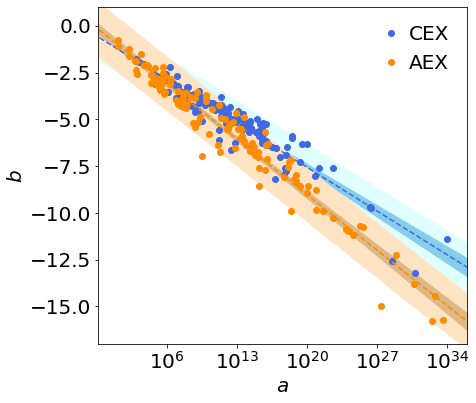

In [12]:
fig, ax = instantiate_fig()
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(-17, 1)

iex_type_list = ['cex', 'aex']
for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'cex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
    elif iex_type == 'aex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
    
    ax.plot(np.exp(x), y, 'o', color = color_1, label=iex_type.upper())
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.legend(loc='upper right', handlelength=0.2, frameon=False)

set_layout(fig, ax)
# fig.savefig(f'./images/noise_problem/b_a_iex_type_CI_PI.png', dpi=300)

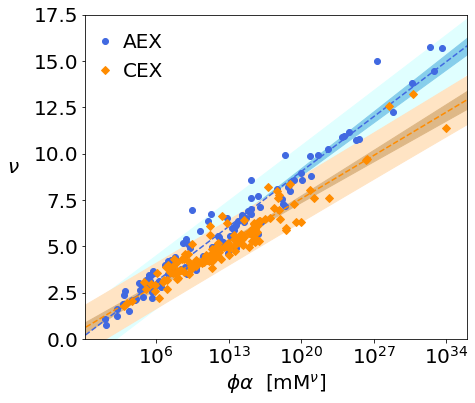

In [13]:
fig, ax = instantiate_fig()
ax.set_xlabel(r'$\phi \alpha$  [mM$^\nu$]')
ax.set_ylabel(r'$\nu$', rotation=0, labelpad=20)

ax.set_xscale('log')
ax.set_xlim(np.exp(-2), np.exp(83))
ax.set_ylim(0, 17.5)

# iex_type_list = ['cex', 'aex']
iex_type_list = ['aex', 'cex']

for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = -1*df.b

    x = data[:,0]
    y = data[:,1]

    x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=10.0)
    
    if iex_type == 'aex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
        marker = 'o'
    elif iex_type == 'cex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
        marker = 'D'
    
    ax.plot(np.exp(x), y, marker, color = color_1, label=iex_type.upper())
    ax.plot(np.exp(x_line), y_line, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = color_3)
    ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = color_2)

ax.legend(loc='upper left', handlelength=0.2, frameon=False)

set_layout(fig, ax)
# fig.savefig(f'./images/manuscript_images/consolidated_data_correlation.pdf')

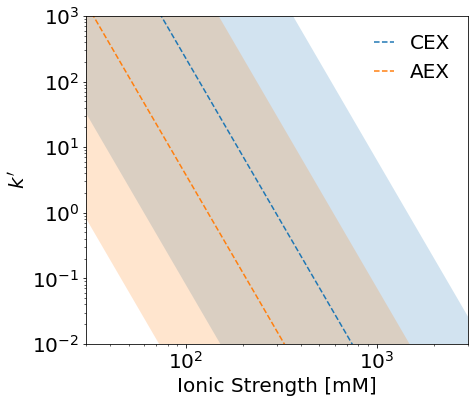

In [14]:
fig, ax = plt.subplots()
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig.set_size_inches(7, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_ylabel("$k'$")
ax.set_xlabel('Ionic Strength [mM]')

iex_type_list = ['cex', 'aex']
for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = df.b

    x = data[:,1]
    y = data[:,0]

    b_val = -5.0
    mu, pre_err_var, low, high = get_stats_from_reg(x, y, b_val)
    a_mean, a_low, a_high = np.exp(mu[0]), np.exp(low[0]), np.exp(high[0])

    tis_new = np.linspace(10, 3e3, 1000)
    k_mean = [a_mean*tis**b_val for tis in tis_new]
    k_low  = [a_low*tis**b_val for tis in tis_new]
    k_high = [a_high*tis**b_val for tis in tis_new]
    
    ax.loglog(tis_new, k_mean, '--', label=iex_type.upper())
    ax.fill_between(tis_new, k_low, k_high, alpha=0.2)

ax.set_ylim(1e-2, 1e3)
ax.set_xlim(30, 3e3)

ax.legend(loc='upper right', handlelength=1.0, frameon=False)
set_layout(ax, fig)
# fig.savefig(f'./images/noise_problem/iex_type_k_both.png', dpi=300)

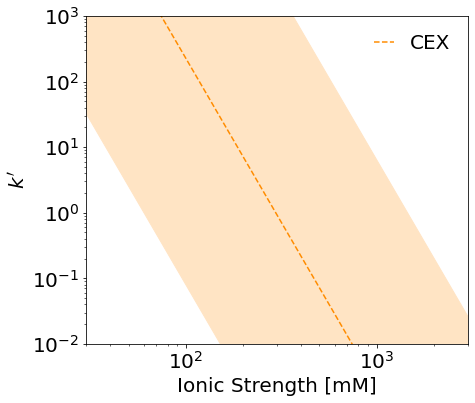

In [18]:
fig, ax = plt.subplots()
params = {'font.weight':'normal', 'font.size':20}
plt.rcParams.update(params)
fig.set_size_inches(7, 6, forward=True)
fig.patch.set_alpha(1.0)
ax.set_ylabel("$k'$")
ax.set_xlabel('Ionic Strength [mM]')

iex_type_list = ['cex']
df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

data = np.zeros((len(df), 2))
data[:,0] = df.ln_a
data[:,1] = df.b

x = data[:,1]
y = data[:,0]

b_val = -5.0
mu, pre_err_var, low, high = get_stats_from_reg(x, y, b_val)
a_mean, a_low, a_high = np.exp(mu[0]), np.exp(low[0]), np.exp(high[0])

tis_new = np.linspace(10, 3e3, 1000)
k_mean = [a_mean*tis**b_val for tis in tis_new]
k_low  = [a_low*tis**b_val for tis in tis_new]
k_high = [a_high*tis**b_val for tis in tis_new]

ax.loglog(tis_new, k_mean, '--', label=iex_type.upper(), color='darkorange')
ax.fill_between(tis_new, k_low, k_high, color='bisque')

ax.set_ylim(1e-2, 1e3)
ax.set_xlim(30, 3e3)

ax.legend(loc='upper right', handlelength=1.0, frameon=False)
set_layout(ax, fig)
fig.savefig(f'./images/noise_problem/iex_type_k_cex.png', dpi=300)

# Updated electrostatics model plot
## Conversion of data to k'
For comparison with augmented data set

In [15]:
# poros_phi_inv_m = {'adh':1.618974E+06,
#                     'blg':4.262758E+06,
#                     'cat':9.307272E+05,
#                     'ova':3.761733E+06}

# resins = ['phq', 'pxq']
# for res in resins:
#     df = pd.read_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' + res + '.csv')
#     for i, cont in df.iterrows():
#         phi = poros_phi_inv_m[cont.protein]
#         df.at[i, 'k_prime'] = cont.Keq * phi
#     df.to_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' + res + '_with_kprime.csv', index=False)

In [60]:
protein_list = ['adh', 'blg', 'cat', 'ova']
resins = ['phq', 'pxq']

temp = []
for res in resins:
    df = pd.read_csv('ns_bim_spherical_pqr/Keq_predictions/Keq_predictions_' + res + '_with_kprime.csv')
    for protein in protein_list:
        df_temp = df[df['protein'] == protein].copy()
        df_temp.rename(columns={'IS(M)': 'IS (M)'}, inplace=True)
        keq_fit_params = optimize.curve_fit(my_fit_function_ln_keq_2, df_temp['IS (M)']*1e3, np.log(df_temp['k_prime']), p0=(1, -50), maxfev=10000)
        temp.append([res, protein, keq_fit_params[0][0], keq_fit_params[0][1]])

df_pred = pd.DataFrame(temp, columns=['resin', 'protein', 'a', 'b'])

## Regression of experimental data
With long extension

In [61]:
# Load data
df_all_k = pd.read_csv('./lit_data/all_kprime.csv')
df_all_k.fillna(0.0, inplace=True)

df_2_fit_parms = pd.read_csv('./lit_data/two_params_all_data.csv')
resins = list(set(df_2_fit_parms.resin))
resins.sort()

df_2_fit_parms['ln_a'] = np.log(df_2_fit_parms.a)
data = np.zeros((len(df_2_fit_parms), 2))
data[:,0] = df_2_fit_parms.ln_a
data[:,1] = df_2_fit_parms.b

In [62]:
x = data[:,0]
y = data[:,1]

x_line, y_line, ci, pi, pred_err_var = get_reg_intervals(x, y, line_extension=100.0)
# fig, ax = plot_intervals(x, y, x_line, y_line, ci, pi)
# ax.set_xlim(np.exp(-2), np.exp(83))
# ax.set_ylim(-17, 1)


## Plot to compare data with electrostatics model

No handles with labels found to put in legend.


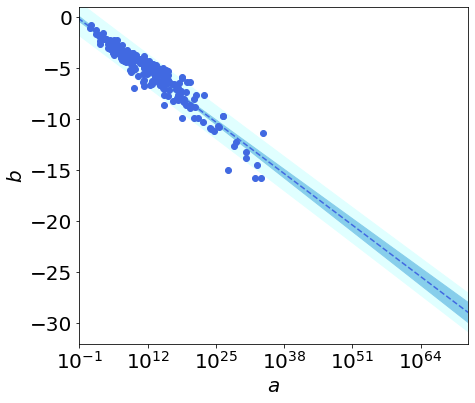

In [70]:
fig, ax = instantiate_fig()
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_xscale('log')

color = 'blue'
ax.plot(np.exp(x), y, 'o', color = 'royalblue')
ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan')
ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue')

ax.set_xlim(1e-1, 1e73)
ax.set_ylim(-32, 1)

ax.legend(loc='lower left', handletextpad=0.5, handlelength=0.3, frameon=False)
set_layout(fig, ax)
fig.savefig('./images/noise_problem/meta_correlation_based_on_kprime.png', dpi=300)

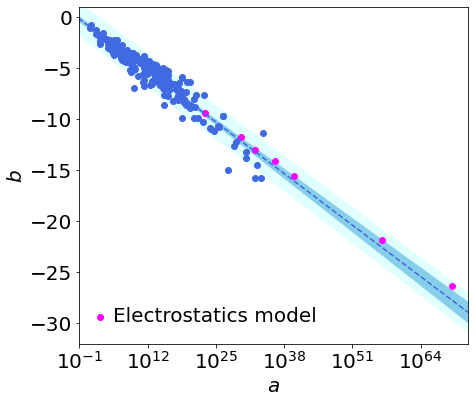

In [71]:
fig, ax = instantiate_fig()
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_xscale('log')

color = 'blue'
ax.plot(np.exp(x), y, 'o', color = 'royalblue')
ax.plot(np.exp(x_line), y_line, color = 'royalblue', linestyle='--')
ax.fill_between(np.exp(x_line), y_line + pi, y_line - pi, color = 'lightcyan')
ax.fill_between(np.exp(x_line), y_line + ci, y_line - ci, color = 'skyblue')

ax.scatter(df_pred['a'], df_pred['b'], label='Electrostatics model', color='magenta')

ax.set_xlim(1e-1, 1e73)
ax.set_ylim(-32, 1)

ax.legend(loc='lower left', handletextpad=0.5, handlelength=0.3, frameon=False)
set_layout(fig, ax)
fig.savefig('./images/noise_problem/meta_correlation_electrostatics_model_based_on_kprime.png', dpi=300)

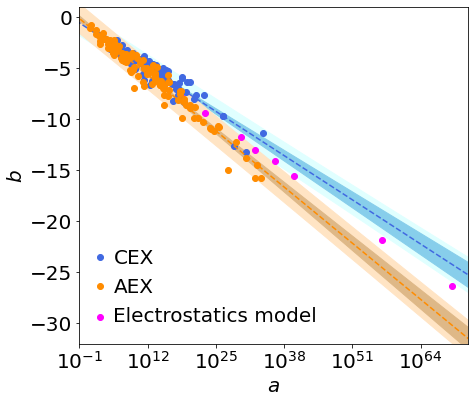

In [72]:
fig, ax = instantiate_fig()
ax.set_xlabel('$a$')
ax.set_ylabel('$b$')
ax.set_xscale('log')

iex_type_list = ['cex', 'aex']
for iex_type in iex_type_list:
    df = df_2_fit_parms[df_2_fit_parms.iex_type==iex_type]

    data = np.zeros((len(df), 2))
    data[:,0] = df.ln_a
    data[:,1] = df.b

    x_iex = data[:,0]
    y_iex = data[:,1]

    x_line_iex, y_line_iex, ci_iex, pi_iex, pred_err_var_iex = get_reg_intervals(x_iex, y_iex, line_extension=100.0)
    
    if iex_type == 'cex':
        color_1, color_2, color_3 = 'royalblue', 'skyblue', 'lightcyan'
    elif iex_type == 'aex':
        color_1, color_2, color_3 = 'darkorange', 'burlywood', 'bisque'
    
    ax.plot(np.exp(x_iex), y_iex, 'o', color = color_1, label=iex_type.upper())
    ax.plot(np.exp(x_line_iex), y_line_iex, color = color_1, linestyle='--')
    ax.fill_between(np.exp(x_line_iex), y_line_iex + pi_iex, y_line_iex - pi_iex, color = color_3)
    ax.fill_between(np.exp(x_line_iex), y_line_iex + ci_iex, y_line_iex - ci_iex, color = color_2)

ax.scatter(df_pred['a'], df_pred['b'], label='Electrostatics model', color='magenta')

ax.set_xlim(1e-1, 1e73)
ax.set_ylim(-32, 1)

ax.legend(loc='lower left', handletextpad=0.5, handlelength=0.3, frameon=False)
set_layout(fig, ax)
fig.savefig('./images/noise_problem/meta_correlation_electrostatics_model_based_on_kprime_cex_aex.png', dpi=300)